# Project 1, Part 5, Data Visualization



# Included Modules and Packages

Code cell containing your includes for modules and packages

In [16]:
import math
import numpy as np
import pandas as pd

import psycopg2

import gmaps
import gmaps.geojson_geometries

from geographiclib.geodesic import Geodesic

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [17]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)
    

In [18]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [19]:
f = open('gmap_api_key.txt', 'r')
my_api_key = f.read()
f.close()

gmaps.configure(api_key=my_api_key)

# 1.5 Example of a Data Visualization created using Python

The data science team would like for you to create an example of a data visualization using Python from data in a Pandas dataframe containing data from an SQL query.

Write 1 and only 1 query.  Note that the query may have as many subqueries, including "with" clauses, as you wish.  Any query of your choosing.  You can write a query from scratch.  You can use a query from a previous problem in this project.  You can use a query from the labs.  The idea is to come up with a query whose resulting data will make for an excellent quality data visualization. 

Ensure that when you check this Juptyer Notebook into GitHub that the query results in the Pandas dataframe are clearly visible in GitHub.  Note: When a query result has a large number of rows, Pandas will only display the first 5 rows, a row with ellipses, and the last 5 rows. This is ok.

Once you have the data in a Pandas dataframe, you may write as much Python code and use as many code cells as you wish to produce the data visualization.

You may only use Python modules that are currently installed in the Anaconda Docker container.  You may not install additional modules or any other software.

All work must be done in Docker in your VM in AWS.  You may not use any external data visualization systems, such as Tableau, etc.

You may use any code from the labs to pattern your code after, however for the data visualization, you cannot wholesale copy a data visualization from the labs.

Ensure that it is properly titled, including titles for axes if present.

Ensure that when you check this Juptyer Notebook into GitHub that the data visualization is clearly visible.  

If you want to use Google Maps for your data visualization, this is fine, however, the image will not show up in GitHub.  So, just save the image to an image file, include it in the repo, and add a markdown cell to display the image file. Also with Google Maps, do NOT check gmap_api_key.txt into GitHub for security reasons.  If the grader needs to run it, they will supply their own gmap_api_key.txt.


## 1.5.1 Project Summary

In this project, we are analyzing the relationship between Acme Gourmet Meals (AGM) and its customers. More specifically, we are interested in visualizing patterns of out-of-city and out-of-state customers based on their transactions.

To accomplish this, we are conducting two types of analyses. First, we are creating visualizations using seaborn and matplotlib to understand the customer's spending patterns in different locations. Second, we are plotting the geographical connections between the customers and the stores using gmaps for a more intuitive geographical representation.

The approach begins with a SQL query to organize and prepare the data, followed by several Python blocks to visualize the data. The end goal is to gain insights into customer behaviors that can help the store optimize its operations and marketing strategy.

## 1.5.2 Data Extraction

In this section, we begin by creating a temporary SQL table 'store_sales_master'. This table contains comprehensive information about the customers, their transactions, and their geographical connection to the stores. It allows us to derive metrics such as 'out_of_city' and 'out_of_state', which indicate whether a customer lives in a different city or state from the store. This code block forms the backbone of our analysis, as the data obtained from this query will be used in all subsequent visualizations.



In [20]:
rollback_before_flag = True
rollback_after_flag = True

query = """

/* Creating a temp table called 'store_sales_master' */
with store_sales_master as (
    /* Inside this temp table, selecting the required columns and calculating 
       the number of transactions, items bought, and amount spent per store */
    select 
        c.zip as customer_zip,
        zc.city as customer_city,
        zc.state as customer_state,
        zc.latitude as customer_latitude,
        zc.longitude as customer_longitude,
        s.store_id,
        st.city as store_city,
        st.state as store_state,
        zc_store.latitude as store_latitude,
        zc_store.longitude as store_longitude,
        count(distinct s.sale_id) as total_transactions, 
        sum(li.quantity) as total_items_bought, 
        sum(s.total_amount) as total_amount_spent,
        /* Adding the 'out_of_city' column */
        case 
            when zc.state = st.state and zc.city != st.city then 'Yes' 
            else 'No' 
        end as out_of_city,
        /* Adding the 'out_of_state' column */
        case 
            when zc.state != st.state then 'Yes' 
            else 'No' 
        end as out_of_state
    from 
        customers c
    /* Joining with 'sales' table on 'customer_id' */
    join 
        sales s on c.customer_id = s.customer_id
    /* Joining with 'line_items' table on 'sale_id' and 'store_id' */
    join 
        line_items li on s.sale_id = li.sale_id and s.store_id = li.store_id
    /* Joining with 'stores' table on 'store_id' */
    join 
        stores st on s.store_id = st.store_id
    /* Joining with 'zip_codes' table to compare customer zip with store city zip and to get the customer city and state */
    join 
        zip_codes zc on c.zip = zc.zip
    /* Joining with 'zip_codes' table again to get store city zip and to get the store city latitude and longitude */
    join
        zip_codes zc_store on st.zip = zc_store.zip
    /* Grouping by 'customer_zip', 'store_id', 'store_city', 'store_state', 'customer_city', 'customer_state' */
    group by 
        c.zip, 
        zc.city,
        zc.state,
        zc.latitude,
        zc.longitude,
        s.store_id, 
        st.city, 
        st.state,
        zc_store.latitude,
        zc_store.longitude,
        zc.zip
)

/* Now, selecting the computed metrics and the newly created columns 'out_of_city' and 'out_of_state' from 'store_sales_master' temp table */
select 
    customer_zip,
    customer_city,
    customer_state,
    customer_latitude,
    customer_longitude,
    store_id,
    store_city,
    store_state,
    store_latitude,
    store_longitude,
    total_transactions, 
    round(total_items_bought / total_transactions, 2) as avg_items_per_transaction, 
    round(total_amount_spent / total_transactions, 2) as avg_amount_per_transaction,
    out_of_city,
    out_of_state
from 
    store_sales_master;


"""

df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df

,customer_zip,customer_city,customer_state,customer_latitude,customer_longitude,store_id,store_city,store_state,store_latitude,store_longitude,total_transactions,avg_items_per_transaction,avg_amount_per_transaction,out_of_city,out_of_state
0,33004,Dania,FL,26.0579,-80.1385,4,Miami,FL,25.7632,-80.1846,46,5.65,303.91,Yes,No
1,33009,Hallandale,FL,25.9857,-80.1479,4,Miami,FL,25.7632,-80.1846,1438,6.08,328.15,Yes,No
2,33010,Hialeah,FL,25.8330,-80.2787,4,Miami,FL,25.7632,-80.1846,6468,5.50,287.86,Yes,No
3,33012,Hialeah,FL,25.8656,-80.3025,4,Miami,FL,25.7632,-80.1846,4509,5.34,278.83,Yes,No
4,33013,Hialeah,FL,25.8623,-80.2703,4,Miami,FL,25.7632,-80.1846,2450,5.44,285.15,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,98403,Tacoma,WA,47.2660,-122.4585,2,Seattle,WA,47.6115,-122.2918,65,5.98,328.62,Yes,No
546,98407,Tacoma,WA,47.2886,-122.5113,2,Seattle,WA,47.6115,-122.2918,114,6.29,341.47,Yes,No
547,98416,Tacoma,WA,47.2625,-122.4812,2,Seattle,WA,47.6115,-122.2918,43,6.14,333.77,Yes,No
548,98421,Tacoma,WA,47.2592,-122.3995,2,Seattle,WA,47.6115,-122.2918,228,6.03,325.74,Yes,No


## 1.5.3 Visualizing Customer Transactions|

In the next section, we move into the visualization phase. Here, we generate a grid of 2x2 subplots using matplotlib and seaborn to showcase:

* The number of out-of-city customers per state.
* The average amount spent per transaction for out-of-city and in-city customers by state.
* The relationship between the average items bought and the average amount spent per transaction.
* The average items bought per transaction for out-of-city and in-city customers by state.

These visualizations provide a clear understanding of customer behavior patterns, differences between in-city and out-of-city customers, and transaction characteristics in different states.



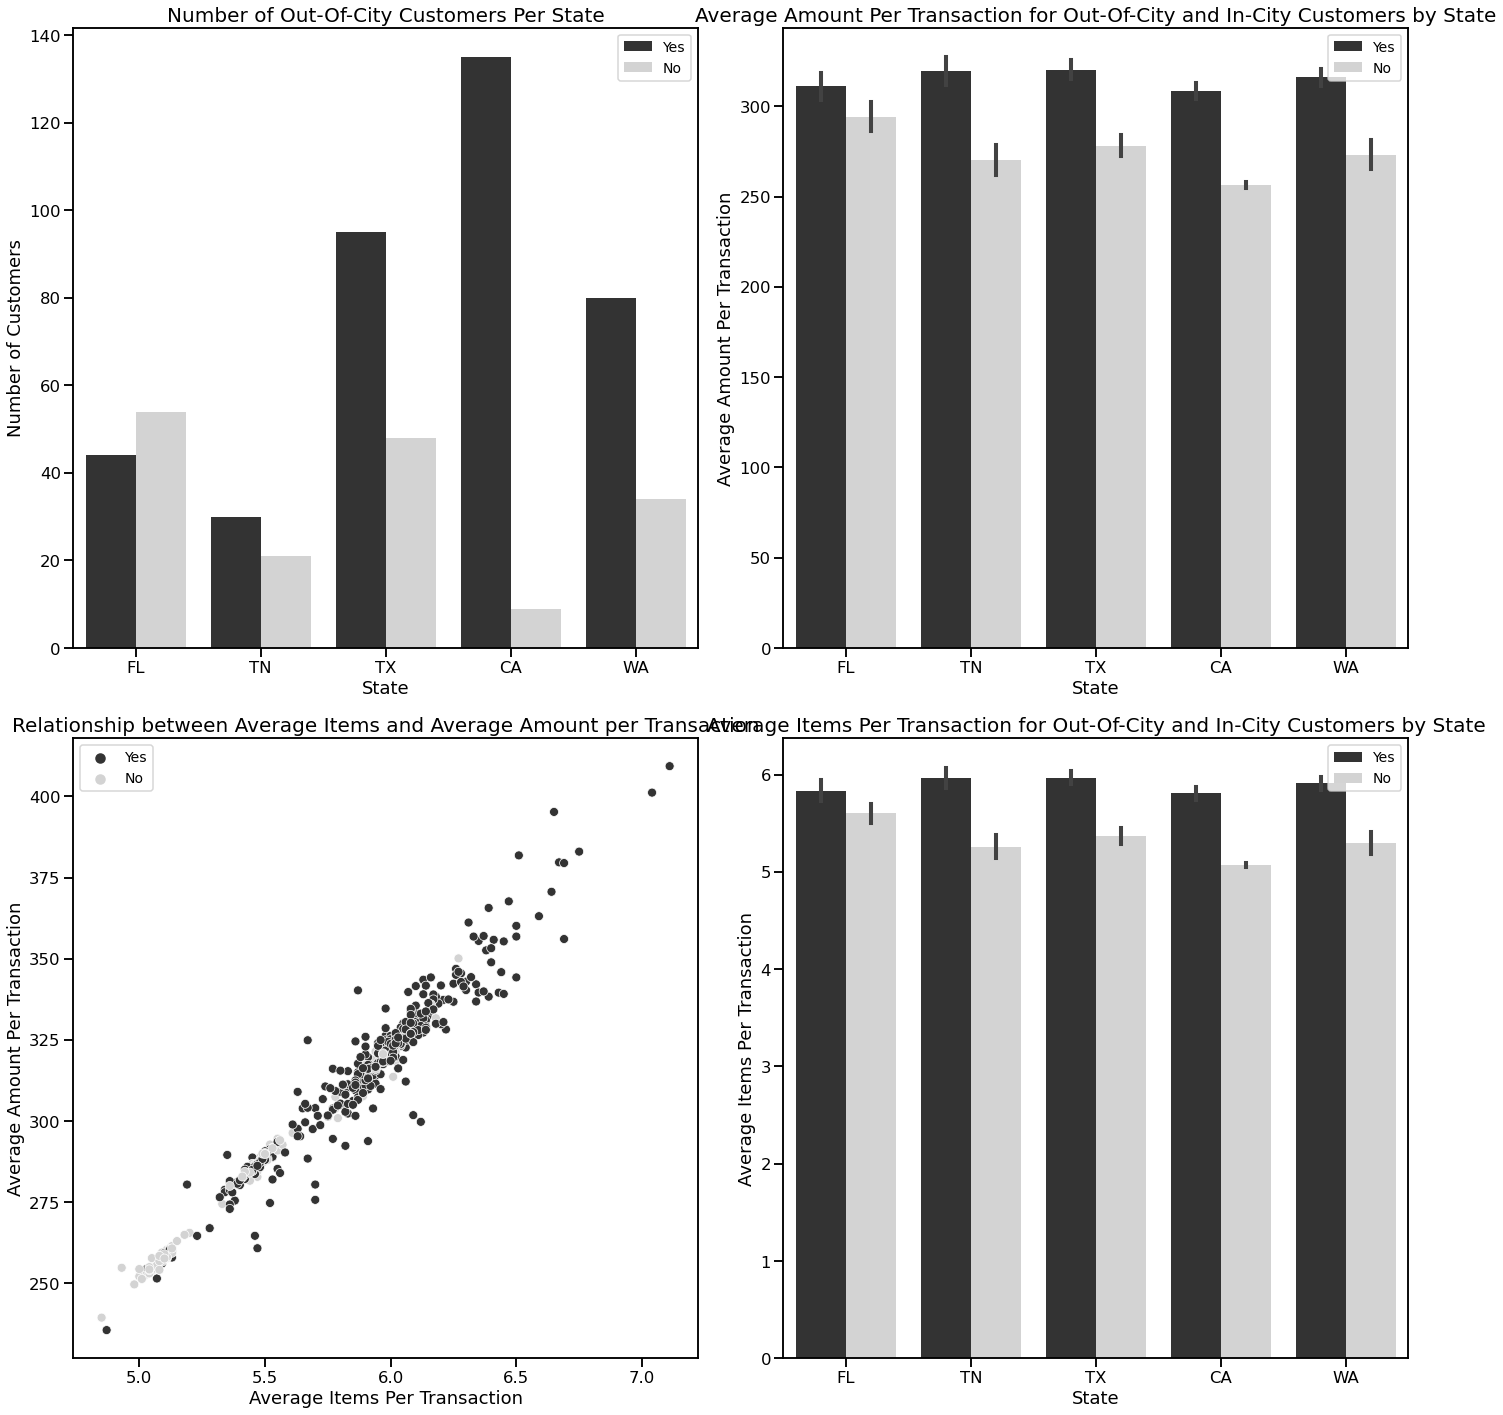

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")  # Increases the size of the labels, ticks and title

fig, ax = plt.subplots(2, 2, figsize=(20, 20)) 

# Query 1
sns.countplot(data=df, x='customer_state', hue='out_of_city', ax=ax[0, 0], palette=['#333333', 'lightgray'])
ax[0, 0].set_title('Number of Out-Of-City Customers Per State', fontsize=20)
ax[0, 0].set_xlabel('State', fontsize=18)
ax[0, 0].set_ylabel('Number of Customers', fontsize=18)
ax[0, 0].legend(fontsize=14)

# Query 2
sns.barplot(data=df, x='customer_state', y='avg_amount_per_transaction', hue='out_of_city', ax=ax[0, 1], palette=['#333333', 'lightgray'])
ax[0, 1].set_title('Average Amount Per Transaction for Out-Of-City and In-City Customers by State', fontsize=20)
ax[0, 1].set_xlabel('State', fontsize=18)
ax[0, 1].set_ylabel('Average Amount Per Transaction', fontsize=18)
ax[0, 1].legend(fontsize=14)

# Query 3
sns.scatterplot(data=df, x='avg_items_per_transaction', y='avg_amount_per_transaction', hue='out_of_city', ax=ax[1, 0], palette=['#333333', 'lightgray'])
ax[1, 0].set_title('Relationship between Average Items and Average Amount per Transaction', fontsize=20)
ax[1, 0].set_xlabel('Average Items Per Transaction', fontsize=18)
ax[1, 0].set_ylabel('Average Amount Per Transaction', fontsize=18)
ax[1, 0].legend(fontsize=14)

# Query 4
sns.barplot(data=df, x='customer_state', y='avg_items_per_transaction', hue='out_of_city', ax=ax[1, 1], palette=['#333333', 'lightgray'])
ax[1, 1].set_title('Average Items Per Transaction for Out-Of-City and In-City Customers by State', fontsize=20)
ax[1, 1].set_xlabel('State', fontsize=18)
ax[1, 1].set_ylabel('Average Items Per Transaction', fontsize=18)
ax[1, 1].legend(fontsize=14)

plt.tight_layout()
plt.show()


#### Image Only

<img src="img/1.png" alt="Image title">

* The number of out-of-city customers per state.
    > This is an interseting insight in that there are more customers outside the city where the store is located. This, along with the 4th chart helps us understand the catchment area (so to speak) for the store and the distance people are willing to drive
* The average amount spent per transaction for out-of-city and in-city customers by state.
    > Out of city customers tend to spend more per transaction than otherwise
* The relationship between the average items bought and the average amount spent per transaction.
    > We expect somewhat of a linear plot for this, which is validated by the chart.
* The average items bought per transaction for out-of-city and in-city customers by state.
    > The average number of items per transaction is higher than what we assumed initially

---

## Customer-Store Geographical Connections

Finally, we leverage the gmaps library to visualize the geographical connections between customers and stores. We focus on the five cities where the stores are located. For each city, we create a separate map showing lines connecting the store in that city to its customers. Each city gets a unique color for its lines for easier identification. This visualization allows us to see the geographical spread of the customers for each store and understand the extent of out-of-city customer presence.

Please note some generalizations done in the master query -- rather than be inundated with very single transaction, this documents takes an aggregate view and is focused more on the location (ie zip codes) where the customers are located

In [22]:
store_cities = {
    1: {"name": "Berkeley", "center": (37.8555, -122.2604), "zoom": 9, "color": "#006400"},
    2: {"name": "Seattle", "center": (47.6114, -122.3214), "zoom": 9, "color": "#8B4513"},
    3: {"name": "Dallas", "center": (32.7958, -96.8015), "zoom": 9, "color": "#B22222"},
    4: {"name": "Miami", "center": (25.772, -80.1891), "zoom": 9, "color": "#8A2BE2"},
    5: {"name": "Nashville", "center": (36.1568, -86.7881), "zoom": 9, "color": "#20B2AA"},
}

### Berkeley Store: Customer Spread

In [23]:
store_id = 1
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Berkeley:


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/2.png" alt="Image title">

### Seattle Store: Customer Spread

In [24]:
store_id = 2
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Seattle:


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/3.png" alt="Image title">

---

### Dallas Store: Customer Spread

In [25]:
store_id = 3
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Dallas:


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/4.png" alt="Image title">

---

### Miami Store: Customer Spread

In [26]:
store_id = 4
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Miami:


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/5.png" alt="Image title">

---

### Nashville Store: Customer Spread

In [27]:
store_id = 5
info = store_cities[store_id]
df_store = df[df['store_id'] == store_id]

lines = []
for idx, row in df_store.iterrows():
    customer_location = (row['customer_latitude'], row['customer_longitude'])
    store_location = (row['store_latitude'], row['store_longitude'])
    lines.append(gmaps.Line(start=customer_location, end=store_location, stroke_weight=1, stroke_color=info['color']))

drawing = gmaps.drawing_layer(features=lines)
fig = gmaps.figure(center=info["center"], zoom_level=info["zoom"])
fig.add_layer(drawing)

# Display the figure
print(f"Customer connections for Store in {info['name']}:")
display(fig)


Customer connections for Store in Nashville:


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/6.png" alt="Image title">

---

---

## Appendix: Supplemental Maps

### Store Locations

> This is a general map showing the greographic distribution of the stores

In [28]:
store_locations = df[['store_latitude', 'store_longitude']]
store_layer = gmaps.marker_layer(store_locations)
fig = gmaps.figure()
fig.add_layer(store_layer)
fig

Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/7.png" alt="Image title">

---

### Heatmap of Customer Locations

> This can help us understand the geographic distribution of your customers. If the heatmap is denser around your store locations, that suggests your customers are mostly local
>> However, since we have aggregate custoemr information, this chart is indicative only and not definitive 

In [29]:
customer_locations = df[['customer_latitude', 'customer_longitude']]
heatmap_layer = gmaps.heatmap_layer(customer_locations)
fig = gmaps.figure()
fig.add_layer(heatmap_layer)
fig


Figure(layout=FigureLayout(height='420px'))

#### Image Only

<img src="img/8.png" alt="Image title">

---